In [9]:
import os
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Model
from keras import Input, Model, layers, regularizers, callbacks
from keras.optimizers.legacy import Adam
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, r2_score
from scipy.stats import pearsonr
import utils_results as ut

In [10]:
basin = 'GLB'
n_clusters = 10
n_vars = 8
n_idxs = 9
results_folder = 'test2_linreg_nc10_nv8_nd9'
model_kind = 'linreg'
n_folds = 3
start_year = 1980
end_year = 2021

In [11]:
# Set project directory and name of file containing the target variable
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
target_file = 'target_1970-2022_2.5x2.5.csv'

# Retrieve the clusters type of data from the results folder
nc_string = results_folder.split('_')[2]
if "A" in nc_string:
    cluster_data = f'{basin}_{n_clusters}clusters_anomaly'
elif "DS" in nc_string:
    cluster_data = f'{basin}_{n_clusters}clusters_deseason'
    target_season = 'target_seasonality_1970-2022_2.5x2.5.csv'
else:
    cluster_data = f'{basin}_{n_clusters}clusters'

# Set the paths to the files
experiment_filename = f'1970-2022_{n_clusters}clusters_{n_vars}vars_{n_idxs}idxs.csv'
sol_filename = f'{model_kind}_' + experiment_filename
predictor_file = 'predictors_' + experiment_filename
fs_dir = os.path.join(project_dir, 'FS_TCG')
output_dir = os.path.join(fs_dir, 'results', basin, results_folder)
sol_path = os.path.join(output_dir, sol_filename)
# final_sol_path = os.path.join(output_dir, f'CRO_{sol_filename}')
best_sol_path = os.path.join(output_dir, f'best_solution_{sol_filename}')
data_dir = os.path.join(fs_dir, 'data', cluster_data)
predictors_path = os.path.join(data_dir, predictor_file)
target_path = os.path.join(data_dir, target_file)
gpis_path = os.path.join(fs_dir, 'data', f'{basin}_2.5x2.5_gpis_time_series.csv')

In [12]:
# Load the predictors and the target in a DataFrame
predictors_df = pd.read_csv(predictors_path, index_col=0)
predictors_df.index = pd.to_datetime(predictors_df.index)
target_df = pd.read_csv(target_path, index_col=0)
target_df.index = pd.to_datetime(target_df.index)
if "DS" in nc_string:
    target_season_df = pd.read_csv(os.path.join(data_dir, target_season), index_col=0)
    target_season_df.index = pd.to_datetime(target_season_df.index)

# Load the gpis time series dataframe and select the target GPIs for physical information to pass to the network
gpis_df = pd.read_csv(gpis_path, index_col=0)
gpis_df.index = pd.to_datetime(gpis_df.index)
gpi_pi = gpis_df['ogpi']

# Load the solutions file in a DataFrame and the best solution found
sol_file_df = pd.read_csv(sol_path, sep=' ', header=0)
best_solution = pd.read_csv(best_sol_path, sep=',', header=None)
best_solution = best_solution.to_numpy().flatten()

In [13]:
# Select the variables from the best solutions and plot it
column_names = predictors_df.columns.tolist()
final_sequence = best_solution[len(column_names):2*len(column_names)]
sequence_length = best_solution[:len(column_names)]
feat_sel = best_solution[2*len(column_names):]
n_rows = len(column_names)
n_cols = int(((sequence_length + final_sequence)*feat_sel).max())

# Create dataset according to solution and list the labels of the selected variables
variable_selection = feat_sel.astype(int)
time_sequences = sequence_length.astype(int)
time_lags = final_sequence.astype(int)
label_selected_vars = []
dataset_opt = target_df.copy()
for c, col in enumerate(predictors_df.columns):
    if variable_selection[c] == 0 or time_sequences[c] == 0:
        continue
    for j in range(time_sequences[c]):
        dataset_opt[str(col) +'_lag'+ str(time_lags[c]+j)] = predictors_df[col].shift(time_lags[c]+j)
        label_selected_vars.append(str(col) +'_lag'+ str(time_lags[c]+j))

In [18]:
# Compone the dataset to train the model using all predictors possible
dataset_opt_noFS = target_df.copy()
for l in range(1):
    for var in predictors_df.columns:
        col_df = pd.DataFrame(predictors_df[var].shift(l).values, index=dataset_opt_noFS.index, columns=[f'{var}_lag{l}'])
        dataset_opt_noFS = pd.concat([dataset_opt_noFS, col_df], axis=1)

2025-02-14 16:42:08.814390: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2025-02-14 16:42:08.814427: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-02-14 16:42:08.814431: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-02-14 16:42:08.814471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-14 16:42:08.814489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-02-14 16:42:09.094716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


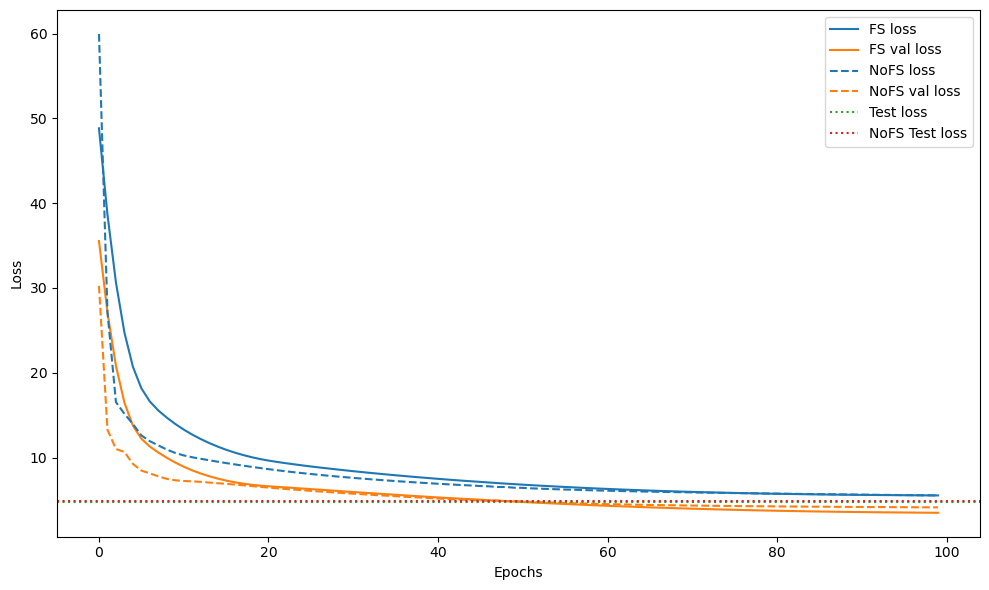

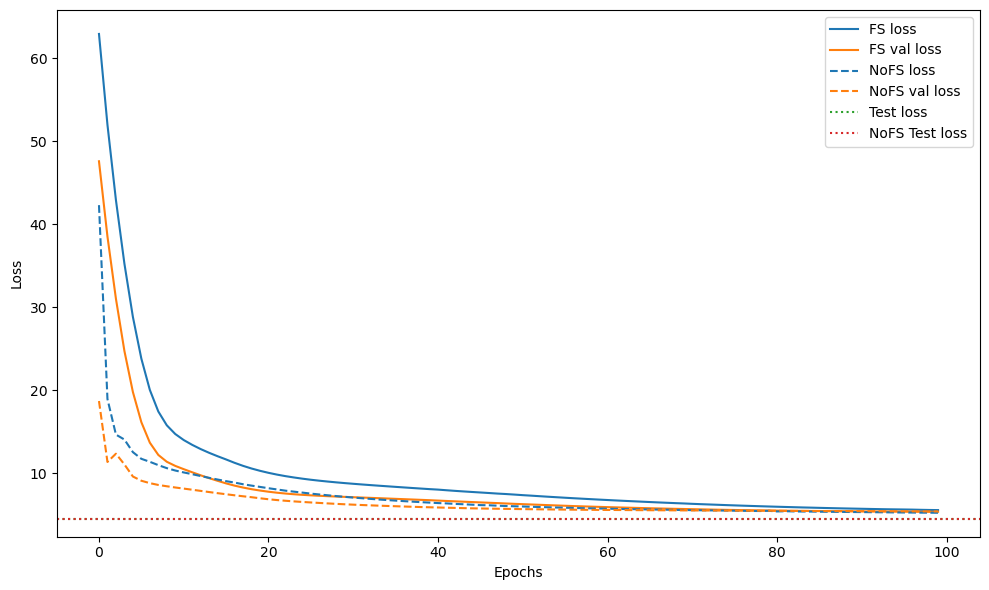

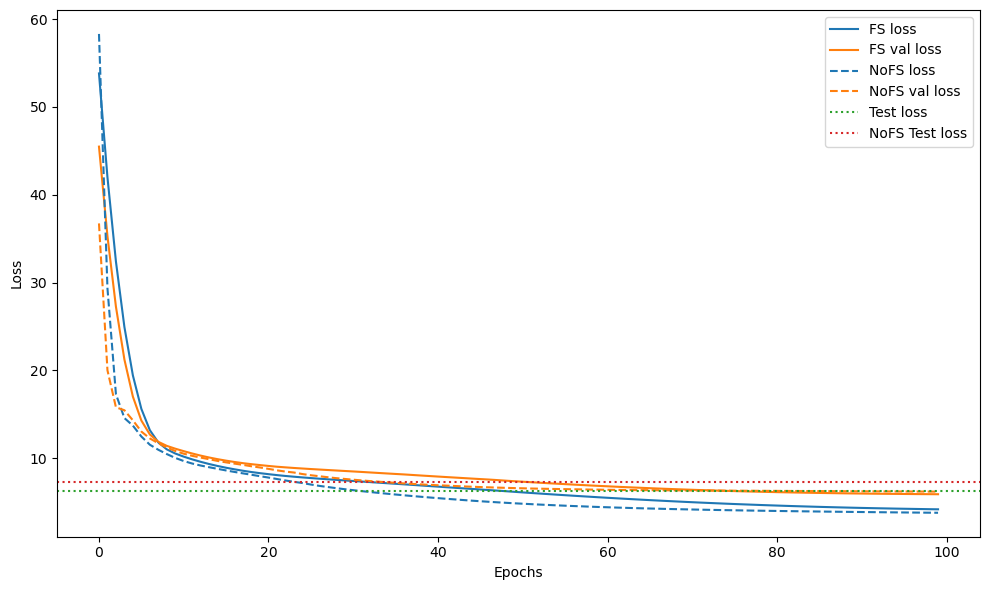

In [19]:
## Train MLPregressor with the best solution found ##
# Cross-Validation for train and test years
years = np.arange(start_year, end_year+1, 1)
kfold = KFold(n_splits=n_folds)
Y_column = 'tcg' # Target variable
obs_indices = dataset_opt.index.year.isin(years)
obs_dataset = dataset_opt[obs_indices]
Y_test = obs_dataset[Y_column]
Y_pred_mlp = pd.DataFrame()
Y_pred_mlp_noFS = pd.DataFrame()
Y_pred_lgbm = pd.DataFrame()
Y_pred_pi_lgbm = pd.DataFrame()
Y_pred_lgbm_noFS = pd.DataFrame()
Y_pred_pi_lgbm_noFS = pd.DataFrame()

for n_fold, (train_index, test_index) in enumerate(kfold.split(years)):

    # Set the indices for the training and test datasets
    train_years = years[train_index]
    test_years = years[test_index]
    # Split the optimized dataset
    train_indices = dataset_opt.index.year.isin(train_years)
    test_indices = dataset_opt.index.year.isin(test_years)
    train_dataset = dataset_opt[train_indices]
    test_dataset = dataset_opt[test_indices]
    # Split the entire dataset 
    train_indices_noFS = dataset_opt_noFS.index.year.isin(train_years)
    test_indices_noFS = dataset_opt_noFS.index.year.isin(test_years)
    train_dataset_noFS = dataset_opt_noFS[train_indices_noFS]
    test_dataset_noFS = dataset_opt_noFS[test_indices_noFS]
    # Split the gpis dataset
    gpi_pi_train = gpi_pi[train_indices]
    gpi_pi_test = gpi_pi[test_indices]

    # Standardize the optimized dataset
    X_train = train_dataset[train_dataset.columns.drop([Y_column])]
    Y_train = train_dataset[Y_column]
    X_test_fold = test_dataset[test_dataset.columns.drop([Y_column])]
    Y_test_fold = test_dataset[Y_column]
    scaler = preprocessing.MinMaxScaler()
    X_std_train = scaler.fit(X_train)
    X_std_train = scaler.transform(X_train)
    X_std_test = scaler.transform(X_test_fold)
    X_train = pd.DataFrame(X_std_train, columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(X_std_test, columns=X_test_fold.columns, index=X_test_fold.index)
    # Standardize the entire dataset
    X_train_noFS = train_dataset_noFS[train_dataset_noFS.columns.drop([Y_column])]
    X_test_fold_noFS = test_dataset_noFS[test_dataset_noFS.columns.drop([Y_column])]
    scaler_noFS = preprocessing.MinMaxScaler()
    X_std_train_noFS = scaler_noFS.fit(X_train_noFS)
    X_std_train_noFS = scaler_noFS.transform(X_train_noFS)
    X_std_test_noFS = scaler_noFS.transform(X_test_fold_noFS)
    X_train_noFS = pd.DataFrame(X_std_train_noFS, columns=X_train_noFS.columns, index=X_train_noFS.index)
    X_test_noFS = pd.DataFrame(X_std_test_noFS, columns=X_test_fold_noFS.columns, index=X_test_fold_noFS.index)

    # Split the training set in training and validation sets for all models and both datasets
    X_t, X_v, Y_t, Y_v, X_t_noFS, X_v_noFS, gpi_pi_t, gpi_pi_v = train_test_split(X_train, Y_train, X_train_noFS, gpi_pi_train, test_size=0.2, random_state=42)

    ## Define common training parameters and callbacks for the mlp ##
    n_neurons = 64
    epo = 100 # Number of epochs
    lr = 0.001 # Learning rate
    l2_reg = 0.001
    batch_size = 32
    callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    ## MLPregressor with Selected Features ##
    # Build and compile the multi layer perceptron model for the optimized dataset
    n_predictors = len(X_train.columns)
    inputs = Input(shape=(n_predictors,))
    x = layers.Dense(n_neurons, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    output = layers.Dense(1)(x)
    mlpreg = Model(inputs, output)
    mlpreg.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    # Prepare training and validation datasets
    train_data = tf.data.Dataset.from_tensor_slices((X_t.values, Y_t.values)).batch(batch_size)
    val_data = tf.data.Dataset.from_tensor_slices((X_v.values, Y_v.values)).batch(batch_size)
    # Train the model
    history = mlpreg.fit(train_data, validation_data=val_data, epochs=epo, callbacks=[callback], verbose=0)
    # Evaluate the model
    Y_pred_fold = mlpreg.predict(X_test, verbose=0)
    Y_pred_fold = pd.DataFrame(Y_pred_fold, index=Y_test_fold.index, columns=['tcg'])
    Y_pred_mlp = pd.concat([Y_pred_mlp, Y_pred_fold])
    loss = mlpreg.evaluate(X_test, Y_test_fold, verbose=0)

    ## MLPregressor with all Features ##
    # Build and compile the multi layer perceptron model for the entire dataset
    n_predictors_noFS = len(X_train_noFS.columns)
    inputs = Input(shape=(n_predictors_noFS,))
    x = layers.Dense(n_neurons, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    output = layers.Dense(1)(x)
    mlpreg_noFS = Model(inputs, output)
    mlpreg_noFS.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    # Prepare training and validation datasets
    train_data = tf.data.Dataset.from_tensor_slices((X_t_noFS.values, Y_t.values)).batch(batch_size)
    val_data = tf.data.Dataset.from_tensor_slices((X_v_noFS.values, Y_v.values)).batch(batch_size)
    # Train the model
    history_noFS = mlpreg_noFS.fit(train_data, validation_data=val_data, epochs=epo, callbacks=[callback], verbose=0)
    # Evaluate the model
    Y_pred_fold_noFS = mlpreg_noFS.predict(X_test_noFS, verbose=0)
    Y_pred_fold_noFS = pd.DataFrame(Y_pred_fold_noFS, index=Y_test_fold.index, columns=['tcg'])
    Y_pred_mlp_noFS = pd.concat([Y_pred_mlp_noFS, Y_pred_fold_noFS])
    loss_noFS = mlpreg_noFS.evaluate(X_test_noFS, Y_test_fold, verbose=0)
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(history.history['loss'], label='FS loss', color='#1f77b4')
    ax.plot(history.history['val_loss'], label='FS val loss', color='#ff7f0e')
    ax.plot(history_noFS.history['loss'], label='NoFS loss', color='#1f77b4', linestyle='--')
    ax.plot(history_noFS.history['val_loss'], label='NoFS val loss', color='#ff7f0e', linestyle='--')
    ax.axhline(y=loss, color='#2ca02c', linestyle=':', label='Test loss')
    ax.axhline(y=loss_noFS, color='#d62728', linestyle=':', label='NoFS Test loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.tight_layout()
    plt.show()

In [20]:
mlpreg.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 22)]              0         
                                                                 
 dense_8 (Dense)             (None, 64)                1472      
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
mlpreg_noFS.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 90)]              0         
                                                                 
 dense_10 (Dense)            (None, 64)                5824      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5889 (23.00 KB)
Trainable params: 5889 (23.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
